In [16]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForCausalLM, BertConfig
import sys
import transformers.models.bert.modeling_bert
import builtins

class BlockImport:
    def __init__(self, *blocked):
        self.blocked = set(blocked)

    def __enter__(self):
        self._orig_import = builtins.__import__

        def fake_import(name, *args, **kwargs):
            if any(name == b or name.startswith(b + ".") for b in self.blocked):
                raise ImportError(f"Blocked import of {name}")
            return self._orig_import(name, *args, **kwargs)

        builtins.__import__ = fake_import

    def __exit__(self, exc_type, exc_value, traceback):
        builtins.__import__ = self._orig_import


class dnalm_embedding_extraction():
    def __init__(self, model_class, model_name, device):
        self.model_class = model_class
        if model_class=="DNABERT2":
            self.model_name = f"zhihan1996/{model_name}"
            # with NoModule("triton"):
            # with NoTriton():
            with BlockImport("triton"):
                self.tokenizer = AutoTokenizer.from_pretrained(
                    self.model_name, trust_remote_code=True
                )
                config = BertConfig.from_pretrained(self.model_name, trust_remote_code=True)
                self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, config=config, trust_remote_code=True)
                self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="HyenaDNA":
            self.model_name = f"LongSafari/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True, padding_side="right")
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True)

        elif model_class=="Nucleotide Transformer":
            self.model_name = f"InstaDeepAI/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="Caduceus":
            self.model_name = f"kuleshov-group/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True, padding_side="right")
            self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="Mistral":
            self.model_name = f"RaphaelMourad/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="GENA-LM":
            self.model_name = f"AIRI-Institute/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModel.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        else:
          print("Model not supported.")
        self.device = device
        self.model.to(self.device)
        self.model.eval()


    @property
    def start_token(self):
        if self.model_class=="HyenaDNA":
            return None
        elif self.model_class=="DNABERT2":
            return 1
        elif self.model_class=="Nucleotide Transformer":
            return 3
        elif self.model_class=="Caduceus":
            return None
        elif self.model_class=="Mistral":
            return 1
        elif self.model_class=="GENA-LM":
            return 1

    @property
    def end_token(self):
        if self.model_class=="HyenaDNA":
            return 1
        elif self.model_class=="DNABERT2":
            return 2
        elif self.model_class=="Nucleotide Transformer":
            return None
        elif self.model_class=="Caduceus":
            return 1
        elif self.model_class=="Mistral":
            return 2
        elif self.model_class=="GENA-LM":
            return 2

    def get_embedding(self, sequences, batch_size):
        embeddings = []
        for i in range(0, len(sequences), batch_size):
            # if i%50000==0:
            #     print(i)
            batch = sequences[i:min(i+batch_size, len(sequences))]

            if self.model_class=="Nucleotide Transformer":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="Mistral":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]

                # mask = clip_mask.unsqueeze(-1)
                # summed = (hidden * mask).sum(dim=1)
                # counts = mask.sum(dim=1).clamp(min=1e-9)
                # mean_embeddings = summed / counts

                last_indices = (ends - 1).clamp(min=0)
                cur_batch_size = hidden.shape[0]
                mean_embeddings = hidden[
                    torch.arange(cur_batch_size, device=hidden.device),
                    last_indices
                ]

            elif self.model_class=="HyenaDNA":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]

                # mask = clip_mask.unsqueeze(-1)
                # summed = (hidden * mask).sum(dim=1)
                # counts = mask.sum(dim=1).clamp(min=1e-9)
                # mean_embeddings = summed / counts

                last_indices = (ends - 1).clamp(min=0)
                cur_batch_size = hidden.shape[0]
                mean_embeddings = hidden[
                    torch.arange(cur_batch_size, device=hidden.device),
                    last_indices
                ]


            elif self.model_class=="DNABERT2":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                # !!! due to the bug in its code, DNABERT2 can only return the last hidden layer
                hidden = torch_outs.hidden_states
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="Caduceus":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="GENA-LM":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            embeddings.append(mean_embeddings.cpu().numpy())
        return np.vstack(embeddings)


    def get_likelihood(self, sequences, batch_size):
        """
        Compute log-likelihoods of sequences.
        Returns: numpy array of log-likelihoods (one per sequence)
        """
        import torch.nn.functional as F

        likelihoods = []

        for i in range(0, len(sequences), batch_size):
            # if i % 50000 == 0:
            #     print(i)
            batch = sequences[i:min(i+batch_size, len(sequences))]

            if self.model_class == "Nucleotide Transformer":

                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            elif self.model_class == "Mistral":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                    )
                    logits = torch_outs.logits.swapaxes(1, 2)
                    lls = torch.zeros(tokens.shape[:2], device=self.device)
                    lls[:,1:] = -F.cross_entropy(logits[:,:,:-1], tokens[:,1:], reduction="none")

                clip_mask = torch.zeros_like(lls)
                for i in range(lls.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))

                seq_likelihoods = (lls * clip_mask).sum(1).numpy(force=True)

            elif self.model_class == "HyenaDNA":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                    )
                    logits = torch_outs.logits.swapaxes(1, 2)
                    lls = torch.zeros(tokens.shape[:2], device=self.device)
                    lls[:,1:] = -F.cross_entropy(logits[:,:,:-1], tokens[:,1:], reduction="none")

                clip_mask = torch.zeros_like(lls)
                for i in range(lls.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))

                seq_likelihoods = (lls * clip_mask).sum(1).numpy(force=True)

            elif self.model_class == "DNABERT2":

                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            elif self.model_class == "Caduceus":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)
            elif self.model_class == "GENA-LM":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            likelihoods.append(seq_likelihoods)

        return np.concatenate(likelihoods)

In [2]:
import pandas as pd

file_path = "/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files/processed_crispri_data.csv"
df = pd.read_csv(file_path)

promoter_seqs = df["promoter_seq"].unique()

In [17]:
## Note:
## Mistral-DNA-v1-1.6B-hg38 not available on HuggingFace anymore

embedding_extractor_hyenaDNA = dnalm_embedding_extraction(model_class="HyenaDNA", model_name="hyenadna-large-1m-seqlen-hf", device=torch.device("cuda"))
embedding_extractor_mistral = dnalm_embedding_extraction(model_class="Mistral", model_name="Mistral-DNA-v1-422M-hg38", device=torch.device("cuda"))

embedding_extractor_dnabert2 = dnalm_embedding_extraction(model_class="DNABERT2", model_name="DNABERT-2-117M", device=torch.device("cuda"))
embedding_extractor_nt = dnalm_embedding_extraction(model_class="Nucleotide Transformer", model_name="nucleotide-transformer-v2-500m-multi-species", device=torch.device("cuda"))
# embedding_extractor_caduceus = dnalm_embedding_extraction(model_class="Caduceus", model_name="caduceus-ps_seqlen-131k_d_model-256_n_layer-16", device=torch.device("cuda"))
embedding_extractor_genalm = dnalm_embedding_extraction(model_class="GENA-LM", model_name="gena-lm-bert-large-t2t", device=torch.device("cuda"))

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT_hyphen_2_hyphen_117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [18]:
all_embeddings = {}
all_embeddings["promoter_seqs"] = promoter_seqs
for embedding_extraction in [embedding_extractor_mistral, embedding_extractor_hyenaDNA, embedding_extractor_dnabert2, embedding_extractor_nt, embedding_extractor_genalm]:
    model_name = embedding_extraction.model_name
    embeddings = embedding_extraction.get_embedding(sequences=promoter_seqs.tolist(), batch_size=20)
    all_embeddings[model_name] = embeddings

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [19]:
import pickle

output_file_path = "/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files/promoter_sequences_and_embeddings.pkl"
with open(output_file_path, 'wb') as f:
    pickle.dump(all_embeddings, f)

In [20]:
!pip install umap-learn --quiet

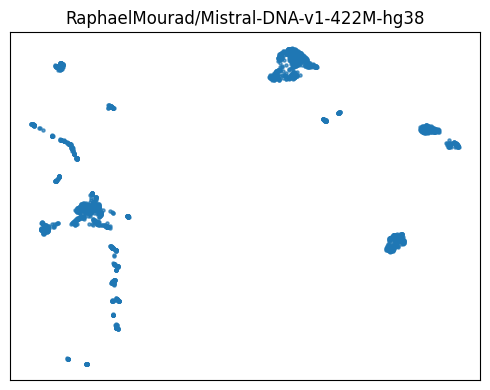

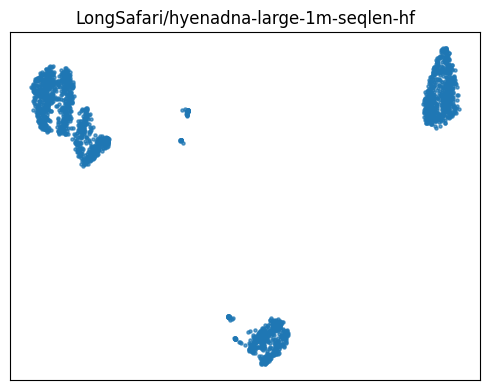

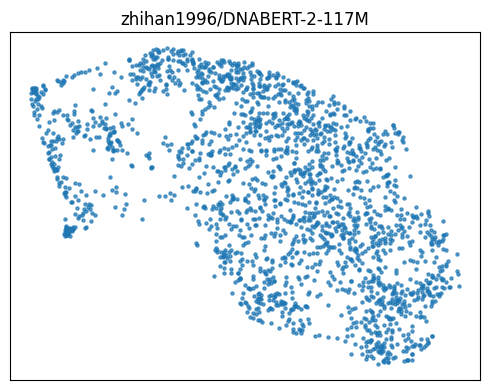

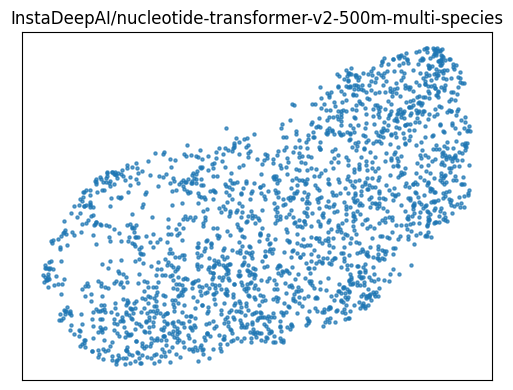

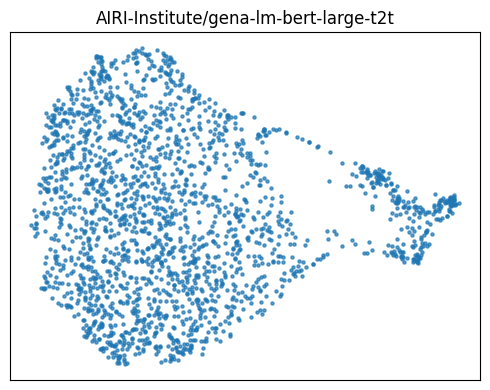

In [22]:
import umap
import matplotlib.pyplot as plt

for embedding_extraction in [
    embedding_extractor_mistral,
    embedding_extractor_hyenaDNA,
    embedding_extractor_dnabert2,
    embedding_extractor_nt,
    embedding_extractor_genalm,
]:
    model_name = embedding_extraction.model_name
    embeddings = all_embeddings[model_name]   # (N, D)

    reducer = umap.UMAP(
        n_neighbors=50,
        min_dist=0.1
    )
    emb_2d = reducer.fit_transform(embeddings)  # (N, 2)

    plt.figure(figsize=(5, 4))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=5, alpha=0.7)
    plt.title(model_name)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()